In [1]:
#pip install ipywidgets
#pip install tqdm

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import json
import os
from IPython.display import display
from tqdm.notebook import tqdm

C:\Users\lsnga\AppData\Local\Temp\ipykernel_11368\1164517705.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Parâmetros de Jogo


## Linhas de Produto, peso e meta

In [2]:
pesos_meta_dict = {

    'Product A':[0.40,225],
    'Product B':[0.20,125],
    'Product C':[0.10,50],
    'Product D':[0.10,40],
    'Product E':[0.06,25],
    'Product F':[0.05,15],
    'Product G':[0.04,10],
    'Product H':[0.04,5],
    'Product I':[0.01,5],
}

linha_principal = list(pesos_meta_dict.keys())[0]

sum_pesos = sum(value[0] for value in pesos_meta_dict.values())

sum_meta = sum(value[1] for value in pesos_meta_dict.values())

peso_geral = 0.60
peso_acelerador = 0.30
peso_adicionais = 1 - peso_geral - peso_acelerador

meta_acelerador = 200


if sum_pesos == 1:
    print(f'Soma dos pesos = 100%! Pesos aprovados!')
    print(f'Soma da meta = {sum_meta}kR$!')
else:
    print(f'Soma dos pesos = {sum_pesos}! Pesos reprovados!')

Soma dos pesos = 1.0000000000000002! Pesos reprovados!


## Parâmetros do jogo

In [3]:
#Definição das macro e micro linhas
macro_linhas = ['Product A', 'Product B', 'Product C']                                                   ## (INPUT) Linhas principais
micro_linhas = [key for key in pesos_meta_dict.keys() if key not in macro_linhas]   ## Outras Linhas

#Valores possíveis para cartas
macro_valores = [50, 60, 70, 80]
micro_valores = [10, 20, 30]

# Definição do Acelerador
linhas_aceleradoras = ['Product A', 'Product D']

# Número de dias simulados
dias_simulados = [5, 10, 15, 20, 25, 30]

#Número de cartas por dia
n_cartas = 4

#Número de linhas macro por dia
n_macro_dia = 1

#Número de cartas puxadas por dia
n_puxadas_dia = 2

#Número de baralhos gerados
n_baralhos = 300

#Número de jogos simulados por baralho (deve ser >50)
n_jogos = 100

#Forçar a puxada da carta macro por dia na simulação (comportamento mais esperado do jogador)
force_macro_pull = True

#Forçar que seja possível atingir 100% na primeira linha (para evitar que a vitória do novo modelo seja causado por falta de vendas da linha principal, o que seria improvável na prática)
froce_fist_line_complete = True

## Parâmetros de aprovação do Baralho


In [4]:
#Número de vitórias relativa
target_vitoria_novo_max = 1.00
target_vitoria_novo_min = 0.5

#Bonus novo médio mínimo 
target_novo_bonus_medio = 0.7

#Atingimento Médio
target_geral_medio_min = 0.85
target_geral_medio_max = 1.1

#Atingimento acelerador Médio

target_acel_medio_min = 0.7
target_acel_medio_max = 1.2

#Melhoria relativa de bonus médio
target_aumento_bonus_max = 1.5
target_aumento_bonus_min = 0.1

#mínimo de atingimento possível para a linha mais importante
target_atingim_minimo_linha_top = 0.85

# Definição de Funções

In [5]:
def gerador_baralho():
    """ Cria-se um baralho randômico para o jogo, dentro das possibilidades da sessão 'Parâmetro de jogo' """

    # Criando os índices (dia-carta).
    lista_cartas = []

    for dia in dias_simulados:
        for x in np.arange(1,n_cartas+1,1):
            lista_cartas.append(str(dia)+'-'+str(x))

    card_table = pd.DataFrame({
        'Dia-Carta': lista_cartas, 
        'Dia': 0, 
        'Carta': 0,
        'Linha': 'TW',
        'Valor': 0,
        'Acelerador':False
        }).set_index('Dia-Carta')

    lista_micro_dia = micro_linhas.copy()
    lista_macro_dia = macro_linhas.copy()

    n_micro_dia = n_cartas-n_macro_dia

    for dia in dias_simulados:
        # Exemplo: se tivermos os dias 10, 20 e 30, e 3 cartas por dia, nos retornará a lista [10-1, 10-2, 10-3, 20-1, 20-2, 20-3, 30-1, 30-2, 30-3]

        ##Quero que todas as linhas possam aparecer pelo menos uma vez em cada jogo
        ##Dessa maneira, o lista_micro_dia e lista_macro_dia só serão resetados para a cópia da lista original caso as listas estejam vazias

        if len(lista_macro_dia)<n_macro_dia:
            lista_macro_dia = macro_linhas.copy()              # No fim do dia, temos todas as macro linhas disponíveis

        if len(lista_micro_dia)<n_micro_dia:
                lista_micro_dia = micro_linhas.copy()          # No início do dia, temos todas as micro linhas disponíveis

        ##O resto do código se mantém da mesma forma, porém

        for carta in np.arange(1,n_cartas+1,1):
            dia_carta = str(dia)+'-'+str(carta)
            card_table.loc[dia_carta,'Dia'] = dia
            card_table.loc[dia_carta,'Carta'] = carta
            
            if carta <= n_macro_dia:                    # Começamos com as cartas macro. Se eu escolhi que n_macro_dia =2, nos dias 1 e 2 as cartas escolhidas serão macro
                if dia == dias_simulados[-1]:           #Vamos forçar que a ultima carta macro do mês seja a de maior peso
                    card_table.loc[dia_carta,'Linha'] = list(pesos_meta_dict.keys())[0]
                else:
                    card_table.loc[dia_carta,'Linha'] = lista_macro_dia.pop(random.randint(0,len(lista_macro_dia)-1))
                    
                card_table.loc[dia_carta,'Valor'] = macro_valores[random.randint(0,len(macro_valores)-1)]
            else:
                card_table.loc[dia_carta,'Linha'] = lista_micro_dia.pop(random.randint(0,len(lista_micro_dia)-1))
                card_table.loc[dia_carta,'Valor'] = micro_valores[random.randint(0,len(micro_valores)-1)]
            
            if card_table.loc[dia_carta,'Linha'] in linhas_aceleradoras:
                card_table.loc[dia_carta,'Acelerador']=True
    
    return card_table

In [6]:
def jogo_simulado(baralho):
    """Função que simula um jogo randômico (puxadas aleatórias) de um baralho gerado na função gerador_baralho()"""

    if n_puxadas_dia > n_cartas:
        return "Numero de puxadas por dia é maior que o número de cartas disponíveis"
    else:
        lista_puxadas = []
        for dia in dias_simulados:
            for x in np.arange(1,n_puxadas_dia+1,1):
                lista_puxadas.append(str(dia)+'-'+str(x))

        jogo = pd.DataFrame({
                'Dia-Puxada': lista_puxadas,
                'Dia': 0,
                'Dia-Carta': 'a', 
                'Linha': 'a',
                'Valor': 0,
                'Acelerador':False
                }).set_index('Dia-Puxada')

        for dia in baralho['Dia'].unique():
            cartas_disponiveis = np.arange(1,n_cartas+1,1).tolist()

            #here we check if any carta with "Linha" that belongs to the macro_linhas
            for _, row in baralho[baralho['Dia']==dia][['Carta', 'Linha']].iterrows():
                carta = row['Carta']
                linha = row['Linha']
                if linha in macro_linhas:
                    carta_prioritaria = carta

            for puxada in np.arange(1,n_puxadas_dia+1,1):
                dia_puxada = str(dia) + '-' + str(puxada)
                #here we check if we toggled the force_macro_pull to true
                #to make sure the simulated player always pull at least one macro_linha card
                #this will be likely to happen in real life, so we will force in the simulation
                if force_macro_pull == True and carta_prioritaria in cartas_disponiveis:
                    cartas_disponiveis.remove(carta_prioritaria)
                    carta_escolhida = carta_prioritaria
                    #carta_escolhida = cartas_disponiveis.pop(carta_prioritaria)
                else:
                    carta_escolhida = cartas_disponiveis.pop(random.randint(0,len(cartas_disponiveis)-1))

                dia_carta = str(dia) + '-' + str(carta_escolhida)
                jogo.loc[dia_puxada, 'Dia'] = dia
                jogo.loc[dia_puxada, 'Dia-Carta'] = dia_carta
                jogo.loc[dia_puxada, 'Linha'] = baralho.loc[dia_carta,'Linha']
                jogo.loc[dia_puxada, 'Valor'] = baralho.loc[dia_carta,'Valor']
                jogo.loc[dia_puxada, 'Acelerador'] = baralho.loc[dia_carta,'Acelerador']

        return jogo

In [7]:
def nivel_bonus(atingimento):
    if atingimento >= 1.2:
        return 'Diamante'
    elif atingimento >= 1.0:
        return 'Ouro'
    elif atingimento >= 0.8:
        return 'Prata'
    else:
        return 'Bronze'

In [8]:
def bonus_isolado(atingimento):

    if atingimento >= 1.2:
        bonus = 1.2

    elif atingimento >= 1.0:
        bonus = atingimento

    elif atingimento >= 0.8:
        if atingimento < 0.85:
            bonus = 0.20
        elif atingimento < 0.90:
            bonus = 0.40
        elif atingimento < 0.95:
            bonus = 0.60
        elif atingimento < 1:
            bonus = 0.90
    else:
        bonus = 0
    
    return bonus

In [9]:
def bonus_modelo_atual_tabela (jogo_da_vez):
        
    totais = pd.DataFrame(jogo_da_vez.groupby('Linha')['Valor'].sum())

    for linha in totais.index:
        totais.loc[linha, 'Meta'] = pesos_meta_dict[linha][1]
        totais.loc[linha, 'Peso'] = pesos_meta_dict[linha][0]

    totais['Atingimento'] = totais['Valor']/totais['Meta']

    totais['Nivel'] = totais['Atingimento'].apply(nivel_bonus)

    totais['Bonus_isolado'] = totais['Atingimento'].apply(bonus_isolado)

    totais['Bonus_Recebido'] = totais['Bonus_isolado']*totais['Peso']

    return totais

In [10]:
def bonus_modelo_atual (jogo_da_vez):
    """Calculamos o bônus recebido pelo vendedor no modelo antigo"""
        
    totais = pd.DataFrame(jogo_da_vez.groupby('Linha')['Valor'].sum())

    for linha in totais.index:
        totais.loc[linha, 'Meta'] = pesos_meta_dict[linha][1]
        totais.loc[linha, 'Peso'] = pesos_meta_dict[linha][0]

    #% de atingimento geral
    totais['Atingimento'] = totais['Valor']/totais['Meta']

    #Avaliação do nível (bronze, prata, ouro, diamante)
    totais['Nivel'] = totais['Atingimento'].apply(nivel_bonus)

    #avaliação do bonus a receber por cada linha de produto
    totais['Bonus_isolado'] = totais['Atingimento'].apply(bonus_isolado)
    totais['Bonus_Recebido'] = totais['Bonus_isolado']*totais['Peso']

    #O vendedor só "libera" o ganho das linhas individuais se atingir o valor mínimo de 80% no atingimento geral
    
    venda_total = totais['Valor'].sum()

    atingimento_geral = venda_total/sum_meta

    if atingimento_geral <0.8:
        bonus_final = 0
    else:
        bonus_final = totais['Bonus_Recebido'].sum()
    
    return bonus_final

In [11]:
def bonus_modelo_novo (jogo_da_vez):
    """Calculamos o bônus recebido pelo vendedor no modelo novo"""

    jogo_da_vez.groupby('Acelerador')['Valor'].sum()

    vendas_gerais = jogo_da_vez['Valor'].sum()

    atingimento_geral = vendas_gerais/sum_meta

    vendas_acelerador = jogo_da_vez[jogo_da_vez['Acelerador']==True]['Valor'].sum()

    atingimento_acelerador = vendas_acelerador/meta_acelerador

    atingimentos = pd.DataFrame({
        'Index': ['Geral', 'Acelerador'],
        'Vendas': [vendas_gerais, vendas_acelerador],
        'Atingimento': [atingimento_geral, atingimento_acelerador]
        }).set_index('Index')

    atingimentos['Nivel'] = atingimentos['Atingimento'].apply(nivel_bonus)

    atingimentos['Bonus'] = atingimentos['Atingimento'].apply(bonus_isolado)

    novo_bonus_final = atingimentos.loc['Geral']['Bonus']*peso_geral + atingimentos.loc['Acelerador']['Bonus']*peso_acelerador

    return novo_bonus_final

In [12]:
def simulador_n_jogos (baralho_da_vez, n_jogos_in = n_jogos):

    results = pd.DataFrame({
                'Round': [],
                'Bonus_Antigo': [],
                'Bonus_Novo':[],
                'Atingimento_Geral':[],
                'Atingimento_Acelerador':[],
                'Melhor_Modelo':'a'
                }).set_index('Round')
    
    for round in range(n_jogos_in):

        jogo_sim = jogo_simulado(baralho=baralho_da_vez)

        results.loc[round, 'Bonus_Antigo']           = bonus_modelo_atual(jogo_da_vez= jogo_sim)
        results.loc[round, 'Bonus_Novo']             = bonus_modelo_novo(jogo_da_vez= jogo_sim)
        results.loc[round, 'Atingimento_Geral']      = jogo_sim['Valor'].sum()/sum_meta
        results.loc[round, 'Atingimento_Acelerador'] = jogo_sim[jogo_sim['Acelerador']==True]['Valor'].sum()/meta_acelerador
        
        if results.loc[round, 'Bonus_Novo'] >= results.loc[round, 'Bonus_Antigo']:
            results.loc[round, 'Melhor_Modelo'] = 'Novo'
        else:
            results.loc[round, 'Melhor_Modelo'] = 'Antigo'

    return results

In [13]:
def avaliador_baralho(baralho_da_vez, Index = 1, n_jogos_in=n_jogos):

    jogos_df = simulador_n_jogos(baralho_da_vez, n_jogos_in)

    novo_win = len(jogos_df[jogos_df['Melhor_Modelo']=='Novo'])
    old_win = len(jogos_df[jogos_df['Melhor_Modelo']=='Antigo'])
    razao_vitoria_novo = novo_win/(old_win+novo_win)

    vendas_maximas_linha_principal = baralho_da_vez[baralho_da_vez['Linha']==linha_principal]['Valor'].sum()
    ating_maximo_linha_principal = vendas_maximas_linha_principal/(pesos_meta_dict[linha_principal][1])

    evaluation = pd.DataFrame({
        'Baralho':                          [Index],
        'razao_vitoria_novo':               razao_vitoria_novo,
        'media_Bonus_Novo':                 jogos_df['Bonus_Novo'].mean(),
        'media_Bonus_Antigo':               jogos_df['Bonus_Antigo'].mean(),
        'media_Atingimento_Geral':          jogos_df['Atingimento_Geral'].mean(),
        'media_Atingimento_Acelerador':     jogos_df['Atingimento_Acelerador'].mean(),
        'Atingimento_maximo_linha_principal': ating_maximo_linha_principal
        })
    
    return evaluation

In [14]:
def lista_baralhos(target_baralhos_aprovados = 1):
    baralho_dict = {}
    notas_list = []
    motivo_erro = []
    baralho_aprovado=0
    print ('Gerando baralhos')
    print ('Target de baralhos aprovados = ' + str(target_baralhos_aprovados))
    
    pbar = tqdm(range(n_baralhos), unit = 'baralho')
    pbar_approved = tqdm(total=target_baralhos_aprovados, unit='baralho aprovado')  # Second progress bar

    for baralho_round in pbar:
        reprovado = False
        baralho_da_vez = gerador_baralho()
        
        avaliador_inicial   = avaliador_baralho(baralho_da_vez=baralho_da_vez, Index=baralho_round, n_jogos_in=20)
        if avaliador_inicial['razao_vitoria_novo'].mean()  < target_vitoria_novo_min:
            continue

        nota_da_vez = avaliador_baralho(baralho_da_vez=baralho_da_vez, Index=baralho_round)

        if nota_da_vez['media_Bonus_Antigo'].mean() == 0:
            aumento_bonus_medio = 0
        else:
            aumento_bonus_medio = nota_da_vez['media_Bonus_Novo'].mean()/nota_da_vez['media_Bonus_Antigo'].mean()

        #region - check for errors avaliador final, criador do motivo da falha
        if  nota_da_vez['razao_vitoria_novo'].mean() < target_vitoria_novo_min:
            reprovado = True
            motivo_erro.append('"razao_vitoria_novo" abaixo')

        if nota_da_vez['razao_vitoria_novo'].mean() > target_vitoria_novo_max:
            reprovado = True
            motivo_erro.append('"razao_vitoria_novo" acima')

        if nota_da_vez['media_Atingimento_Geral'].mean() < target_geral_medio_min:
            reprovado = True
            motivo_erro.append('"media atingimento geral" abaixo')

        if nota_da_vez['media_Atingimento_Geral'].mean() > target_geral_medio_max:
            reprovado = True
            motivo_erro.append('"media atingimento geral" acima')

        if nota_da_vez['media_Atingimento_Acelerador'].mean() < target_acel_medio_min:
            reprovado = True
            motivo_erro.append('"media atingimento acelerador" abaixo')

        if nota_da_vez['media_Atingimento_Acelerador'].mean() > target_acel_medio_max:
            reprovado = True
            motivo_erro.append('"media atingimento acelerador" acima')

        if aumento_bonus_medio < target_aumento_bonus_min:
            reprovado = True
            motivo_erro.append('"aumento_bonus_medio" abaixo')

        if aumento_bonus_medio > target_aumento_bonus_max:
            reprovado = True
            motivo_erro.append('"aumento_bonus_medio" acima')

        if nota_da_vez['Atingimento_maximo_linha_principal'].mean() < target_atingim_minimo_linha_top:
            reprovado = True
            motivo_erro.append('baixo atingimento maximolinha top')

        if reprovado == True:
            continue
        #endregion

        baralho_dict[baralho_round] = baralho_da_vez
        notas_list.append(nota_da_vez)
        notas = pd.concat(notas_list)
        baralho_aprovado += 1  # Increment the counter
        pbar_approved.update(1)
        pbar.set_postfix({'Baralhos Aprovados': baralho_aprovado})
        #if we get to the target_baralhos_aprovados, we break from the main for loop
        if baralho_aprovado >= target_baralhos_aprovados:
            break

    
    pbar_approved.close()

    if baralho_aprovado > 0:
        notas.set_index('Baralho', inplace=True)
    else:
        notas = []
        
    return baralho_dict, notas, motivo_erro


# Gerando baralhos randômicos

- Nesse estágio, nosso código irá gerar baralhos randômicos na função <font color='yellow'>gerador_baralho()</font>
- Cada baralho gerado passará por <font color='teal'>n_jogos</font> randômicos na função <font color='yellow'>simulador_n_jogos()</font>
- O resultado desses jogos será cruzado com nossos [PARÂMETROS DE APROVAÇÃO DE BARALHO](#parâmetros-do-jogo) na função <font color='yellow'>avaliador_baralho()</font>
- Na função <font color='yellow'>lista_baralho()</font>, finalmente, avaliações positivas em todos os parâmetros incluem o baralho na lista de <font color='teal'>baralho_dict</font>, com as respectivas <font color='teal'>notas</font>
- Na mesma função, os motivos da reprovação do baralho são somatizadas no dataframe <font color='teal'>motivo_erro</font>

In [15]:
baralho_dict, notas_geradas,motivo_erro = lista_baralhos(
    target_baralhos_aprovados=10                            # se atingirmos esse número de baralhos aprovados, encerramos o loop de geração
    )

Gerando baralhos
Target de baralhos aprovados = 10


  0%|          | 0/300 [00:00<?, ?baralho/s]

  0%|          | 0/10 [00:00<?, ?baralho aprovado/s]

## Avaliando Reprovações

In [16]:
motivo_erro_counts = pd.Series(motivo_erro).value_counts()
print(motivo_erro_counts)


"aumento_bonus_medio" acima              46
baixo atingimento maximolinha top        43
"media atingimento acelerador" acima      6
"media atingimento acelerador" abaixo     3
"media atingimento geral" acima           2
Name: count, dtype: int64


## Avaliando Aprovações

In [17]:
notas_geradas.sort_values(by='razao_vitoria_novo', ascending=False)

,razao_vitoria_novo,media_Bonus_Novo,media_Bonus_Antigo,media_Atingimento_Geral,media_Atingimento_Acelerador,Atingimento_maximo_linha_principal
Baralho,,,,,,
24,1.00,0.99273,0.85892,1.0728,1.1825,0.977778
28,1.00,0.98301,0.75688,1.0756,1.1430,0.933333
40,1.00,0.99249,0.77260,1.0884,1.1520,0.933333
51,1.00,0.94236,0.63348,1.0206,1.1135,0.888889
53,1.00,0.97110,0.72456,1.0608,1.1235,0.933333
62,1.00,0.94632,0.69580,1.0318,1.1220,0.933333
68,1.00,0.94083,0.64720,1.0174,1.1400,0.888889
69,1.00,0.91659,0.65308,1.0082,1.0665,0.888889
34,0.99,0.89025,0.67152,0.9826,1.1355,0.933333


In [18]:
exemplo_baralho_top = baralho_dict[notas_geradas.index[0]]
exemplo_baralho_top.set_index(['Dia', 'Carta'])

Linha  Valor  Acelerador
Dia Carta                              
5   1      Product C     70       False
    2      Product H     20       False
    3      Product F     20       False
    4      Product D     10        True
10  1      Product B     60       False
    2      Product G     20       False
    3      Product I     10       False
    4      Product E     30       False
15  1      Product A     80        True
    2      Product G     30       False
    3      Product F     20       False
    4      Product D     20        True
20  1      Product A     80        True
    2      Product I     30       False
    3      Product E     10       False
    4      Product H     10       False
25  1      Product B     80       False
    2      Product F     20       False
    3      Product D     20        True
    4      Product H     10       False
30  1      Product A     60        True
    2      Product E     10       False
    3      Product I     10       False
    4      Product G     20       False

In [19]:
jogo_simulado(exemplo_baralho_top)

,Dia,Dia-Carta,Linha,Valor,Acelerador
Dia-Puxada,,,,,
5-1,5,5-1,Product C,70,False
5-2,5,5-4,Product D,10,True
10-1,10,10-1,Product B,60,False
10-2,10,10-3,Product I,10,False
15-1,15,15-1,Product A,80,True
15-2,15,15-4,Product D,20,True
20-1,20,20-1,Product A,80,True
20-2,20,20-2,Product I,30,False
25-1,25,25-1,Product B,80,False


## Validação do Baralho - Resultado de 5.000 jogos

In [20]:
sim_results = simulador_n_jogos(
    baralho_da_vez=exemplo_baralho_top, 
    n_jogos_in = 5000
    )


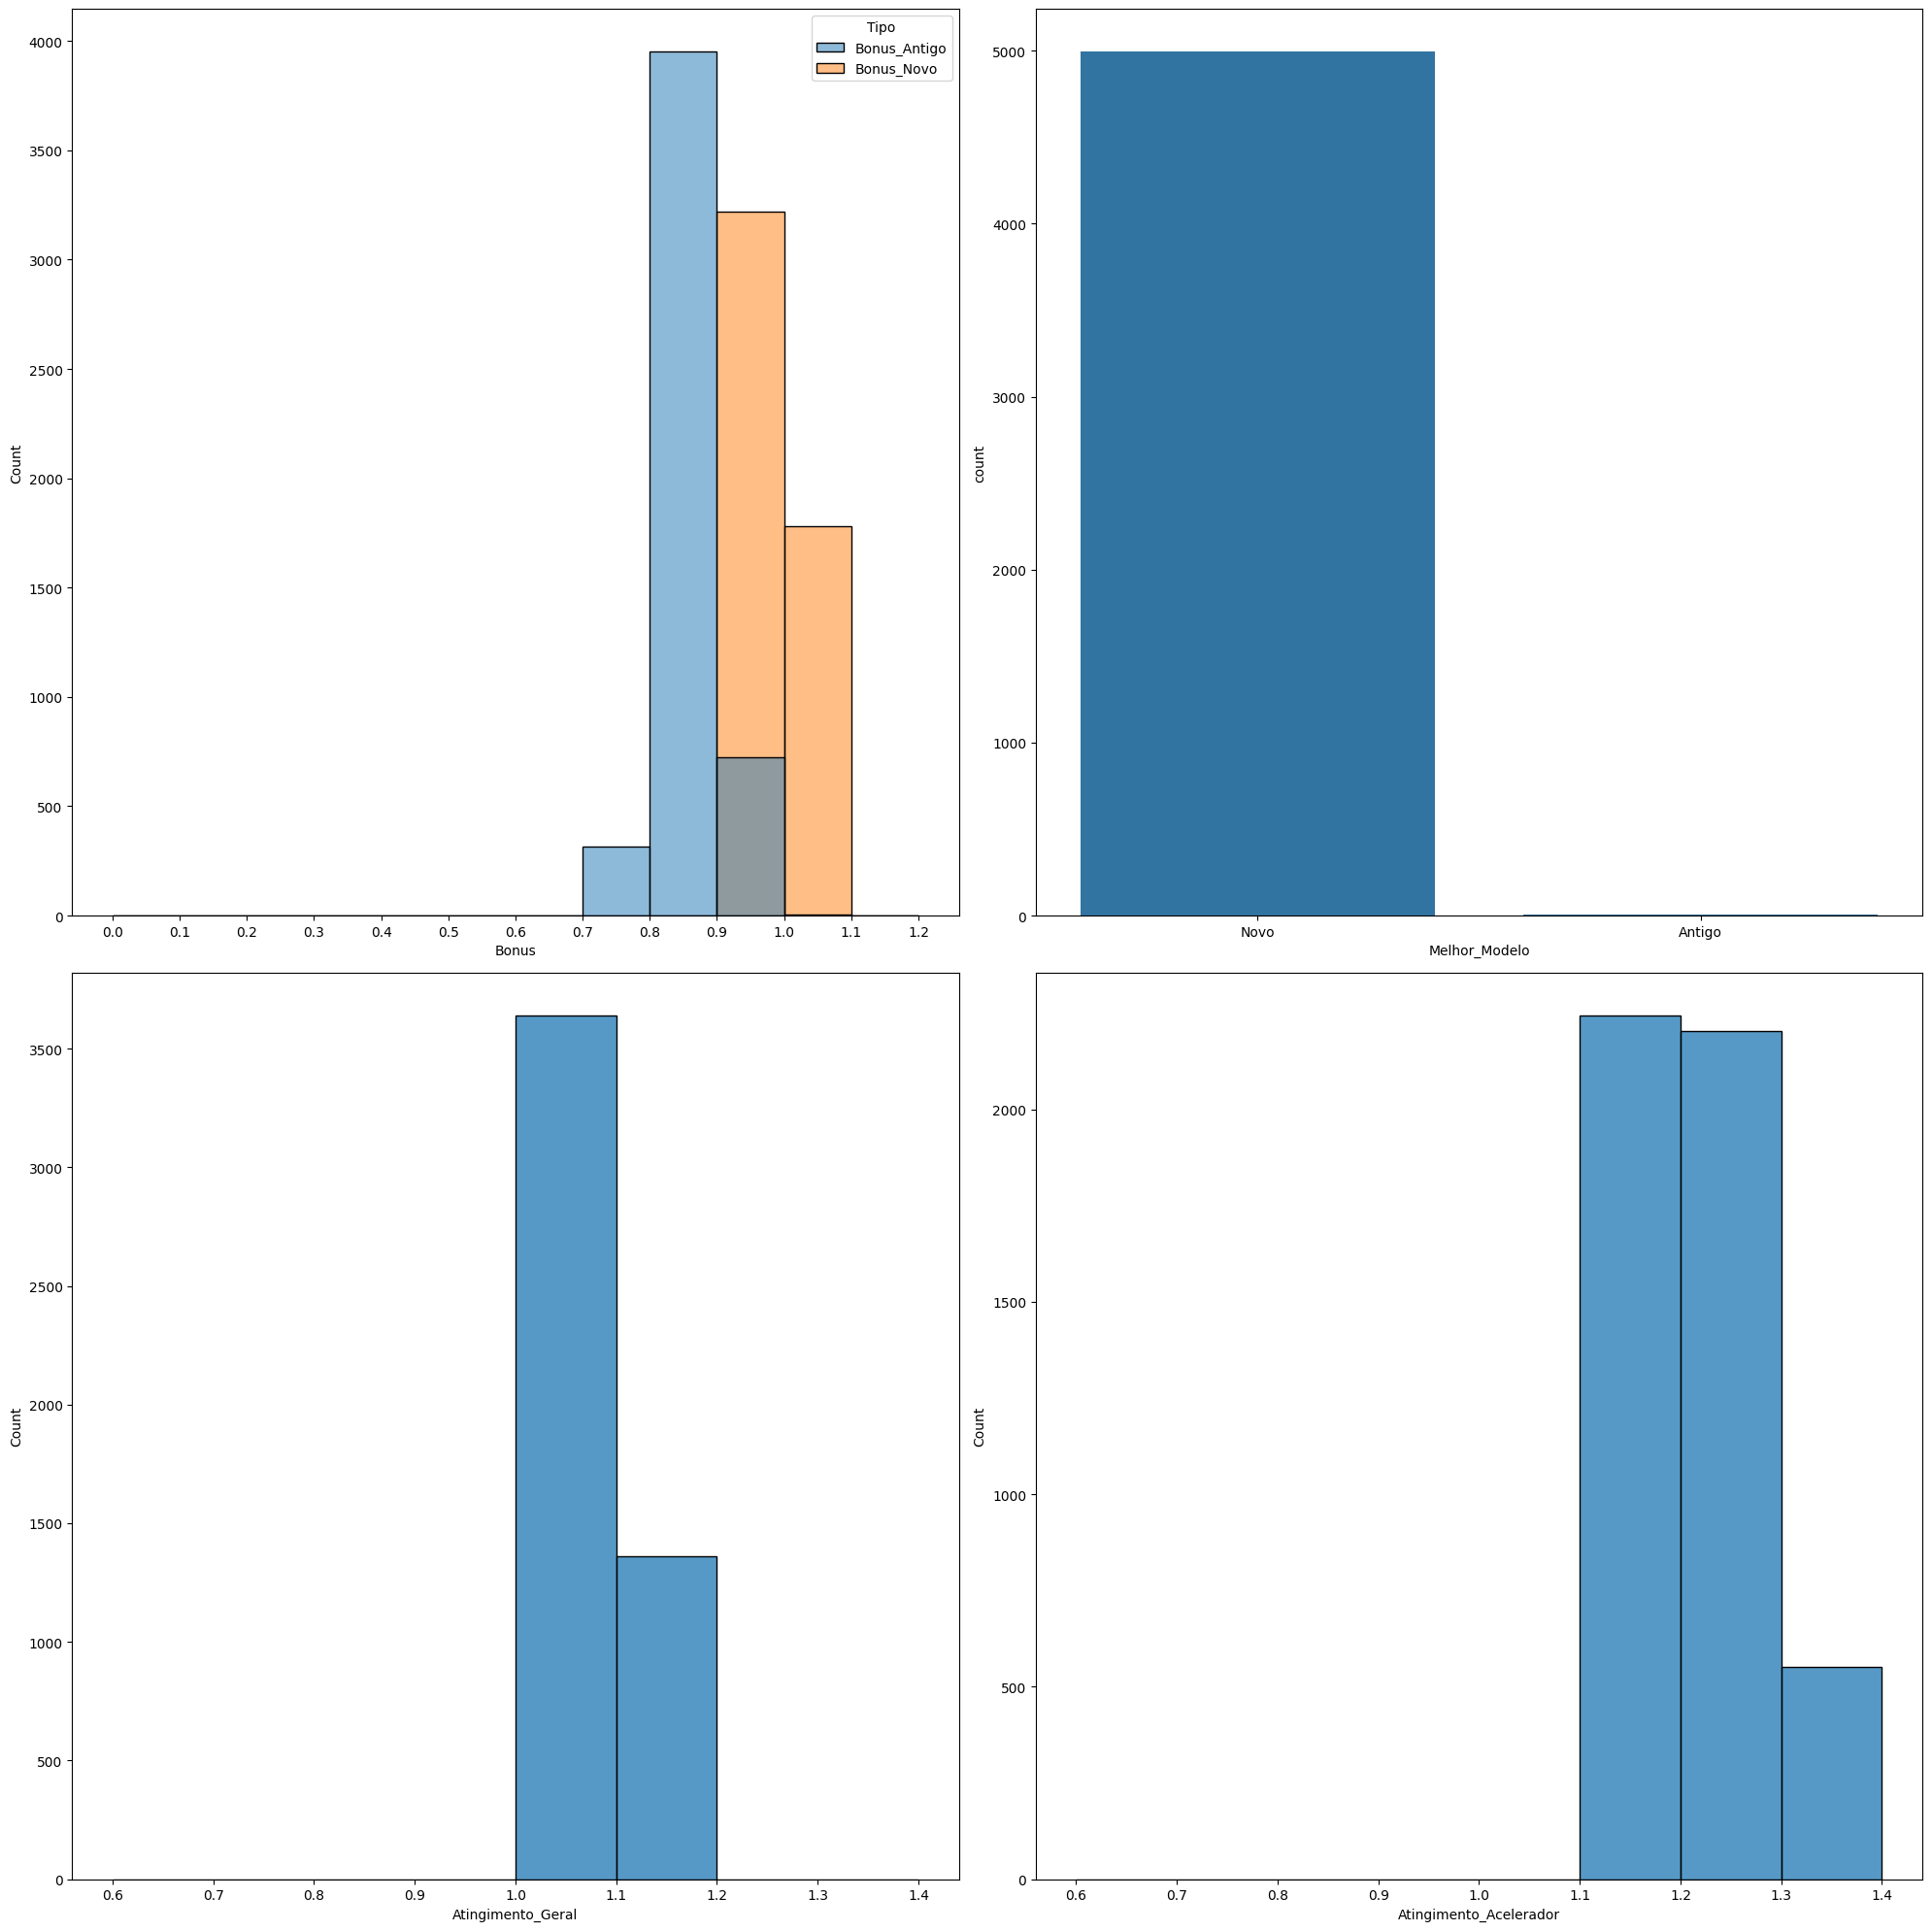

In [21]:
bonus_hist = sim_results[['Bonus_Antigo','Bonus_Novo']].unstack().reset_index().rename({'level_0':"Tipo", 0:'Bonus'},axis=1).drop('Round', axis = 1)

fig,axes = plt.subplots(2,2,figsize=(20,20))

axes_flat = axes.flatten()

sns.histplot(
    ax = axes_flat[0],
    data = bonus_hist,
    x = "Bonus",
    hue = 'Tipo',
    bins = np.arange(0,1.3,0.1)
)
axes_flat[0].set_xticks(np.arange(0,1.3,0.1))

sns.countplot(
    ax = axes_flat[1],
    data = sim_results,
    x = "Melhor_Modelo"
)

sns.histplot(
    ax = axes_flat[2],
    data = sim_results,
    x = "Atingimento_Geral",
    bins = [0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4]
)
sns.histplot(
    ax = axes_flat[3],
    data = sim_results,
    x = "Atingimento_Acelerador",
    bins = [0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4]
)

plt.tight_layout()
plt.show()

# Criação de arquivo json para alimentar o jogo

In [22]:
# Convert each DataFrame in the dictionary to a dictionary
baralho_dict_serializable = {k: v.to_dict() for k, v in baralho_dict.items()}

data = {
    "pesos_meta_dict":      pesos_meta_dict,
    "peso_geral":           peso_geral,
    "peso_acelerador":      peso_acelerador,
    "meta_acelerador":      meta_acelerador,
    "linhas_aceleradoras":  linhas_aceleradoras,
    "baralho_dict":         baralho_dict_serializable
}

with open('game_file.json', 'w') as f:
    json.dump(data, f)

# Checking the game file

In [23]:
import pandas as pd
import json
import random
import os

# Specify the folder path where the JSON files are located
folder_path = os.path.join('Game_Setups')

# Get a list of all JSON files in the folder
json_files = [file for file in os.listdir('Game_Setups') if file.endswith('.json')]

# Select a random JSON file from the list
random_file = random.choice(json_files)

# Read the selected JSON file
with open(os.path.join(folder_path, random_file), 'r') as f:
    data = json.load(f)

json_pesos_meta_dict = data['pesos_meta_dict']
json_linhas_aceleradoras = data['linhas_aceleradoras']

# Convert each dictionary in baralho_dict back to a DataFrame
json_baralho_dict = {k: pd.DataFrame(v) for k, v in data['baralho_dict'].items()}